In [1]:
import os
from os.path import join as opj

In [2]:
import nipype.interfaces.fsl.preprocess as ni_fsl_preproc
import nipype.interfaces.ants as ni_ants
import nipype.interfaces.utility as ni_util # IdentityInterface
import nipype.interfaces.io as ni_io # SelectFiles, DataSink
import nipype.pipeline.engine as ni_engine # Workflow, Node

In [3]:
experiment_dir = '/home/dave/Temp/nhw_test/wmh_derivatives'
output_dir = 'datasink'
working_dir = 'wd'

In [4]:
# ANTs: Rigid registration of T1 to FLAIR
ants_reg = ni_engine.Node(ni_ants.Registration(dimension=3,
                                               transforms=['Rigid'],
                                               transform_parameters=[(0.1,)],
                                               metric=['MI'],
                                               metric_weight=[1.0],
                                               number_of_iterations=[[1000]],
                                               convergence_threshold=[1.e-6],
                                               convergence_window_size=[10],
                                               shrink_factors=[[4]],
                                               smoothing_sigmas=[[2.]],
                                               # write_composite_transform=True,
                                               output_warped_image=True,
                                               output_transform_prefix='T1w_to_FLAIR'),
                         name='ants_reg')
# BET: skullstrip T1
bet_t1 = ni_engine.Node(ni_fsl_preproc.BET(frac=0.3,
                                           robust=True,
                                           output_type='NIFTI_GZ',
                                           mask=True),
                        name="bet_t1")

ants_warp = ni_engine.Node(ni_ants.ApplyTransforms(dimension=3,
                                                     interpolation='NearestNeighbor',
                                                     invert_transform_flags=[True],
                                                          default_value=0),
                                  name='ants_warp')

170906-19:27:34,105 interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [5]:
# Manually defined lists for now
site_top_list = ('Amst',)
site_bot_list = ('GE3T',)
# sub_list = ('100', '101', '102')
sub_list = ('100',)


# Infosource
infosource = ni_engine.Node(ni_util.IdentityInterface(fields=['site_top', 'site_bot', 'subject_id']),
                  name="infosource")
infosource.iterables = [('site_top', site_top_list),
                        ('site_bot', site_bot_list),
                        ('subject_id', sub_list)]

# SelectFiles
t1_file = opj('wmh', '{site_top}', '{site_bot}', '{subject_id}', 'orig', '3DT1.nii.gz')
flair_file = opj('wmh', '{site_top}', '{site_bot}',
                 '{subject_id}', 'orig', 'FLAIR.nii.gz')
lesion_file = opj('wmh', '{site_top}', '{site_bot}',
                  '{subject_id}', 'wmh.nii.gz')

templates = {'t1': t1_file,
             'flair': flair_file,
             'lesion': lesion_file}
selectfiles = ni_engine.Node(ni_io.SelectFiles(templates,
                                               base_directory='/home/dave/Temp/nhw_test',
                                               sort_filelist=True),
                             name="selectfiles")
                            
# Datasink - creates output folder for important outputs
datasink = ni_engine.Node(ni_io.DataSink(base_directory=experiment_dir,
                                         container=output_dir),
                          name="datasink")

In [6]:
# Create the preprocessing workflow
preproc = ni_engine.Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('site_top', 'site_top'),
                                            ('site_bot', 'site_bot'),
                                            ('subject_id', 'subject_id')]),
                 (selectfiles, bet_t1, [('t1', 'in_file')]),
                 (selectfiles, ants_reg, [('t1', 'moving_image'),
                                          ('flair', 'fixed_image')]),
                 (ants_reg, ants_warp, [('reverse_transforms', 'transforms')]),
                 (selectfiles, ants_warp, [('t1', 'reference_image'),
                                           ('lesion', 'input_image')]),
                 (bet_t1, datasink, [('out_file', 'preproc'),
                                     ('mask_file', 'preproc.@mask')]),
#                  (ants_reg, datasink, [('composite_transform', 'preproc.@t1_to_flair_tf'),
#                                        ('inverse_composite_transform', 'preproc.@flair_to_t1_tf'),
#                                        ('warped_image', 'preproc.@t1_to_flair_nii')]),
                 (ants_reg, datasink, [('composite_transform', 'preproc.@t1_to_flair_tf'),
                                       ('inverse_composite_transform', 'preproc.@flair_to_t1_tf')]),
                 (ants_warp, datasink, [('output_image', 'preproc.@lesion_to_t1_nii')])
                 ])

170906-19:27:35,310 workflow INFO:
	 Generated workflow graph: /home/dave/Temp/nhw_test/wmh_derivatives/wd/preproc/graph.dot.png (graph2use=colored, simple_form=True).


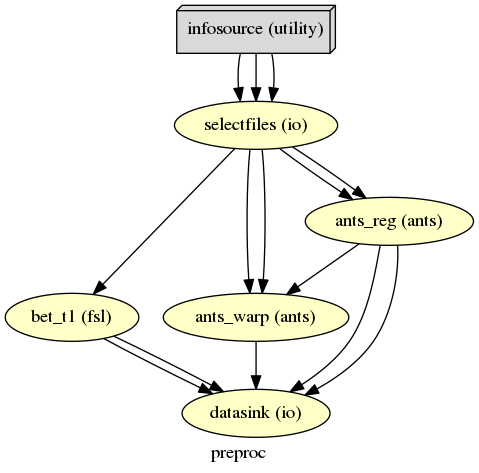

In [7]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
import IPython.display
IPython.display.Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

In [8]:
preproc.run('MultiProc', plugin_args={'n_procs': 1})

170906-19:27:35,370 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170906-19:27:35,389 workflow INFO:
	 Running in parallel.
170906-19:27:35,392 workflow INFO:
	 Executing: selectfiles.a0 ID: 0
170906-19:27:35,400 workflow INFO:
	 Executing node selectfiles.a0 in dir: /home/dave/Temp/nhw_test/wmh_derivatives/wd/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/selectfiles
170906-19:27:35,417 workflow INFO:
	 [Job finished] jobname: selectfiles.a0 jobid: 0
170906-19:27:35,421 workflow INFO:
	 Executing: bet_t1.a0 ID: 1
170906-19:27:35,424 workflow INFO:
	 [Job finished] jobname: bet_t1.a0 jobid: 1
170906-19:27:35,431 workflow INFO:
	 Executing: ants_reg.a0 ID: 2
170906-19:27:35,441 workflow INFO:
	 Executing node ants_reg.a0 in dir: /home/dave/Temp/nhw_test/wmh_derivatives/wd/preproc/_site_bot_GE3T_site_top_Amst_subject_id_100/ants_reg
170906-19:27:35,461 workflow INFO:
	 Running: antsRegistration --collapse-output-transforms 0 --dimensionality 3 --initi